In [1]:
# ce notebook fait une analyse du retard en fonction du temps 
import numpy as np 
import pandas as pd 
import scipy as sc 
import matplotlib.pyplot as plt 
from itertools import product
from sklearn import linear_model
from sklearn.utils import shuffle
import seaborn as sns

import missingno as msno

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import neighbors, metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import dummy

from sklearn import (manifold, datasets, decomposition, ensemble,discriminant_analysis, random_projection)

In [2]:
# ouvrir le dataset : 
data_fly = pd.read_csv('DF_DATE.csv')

Ce notebook fait une première analyse en considérant uniquement les variables de temps, on ajoute progressivement des variables de temps, On modélise en incorporant des regressions linéaires avec introduction de features polynomiales. on évalue via validation croisée en on compare les RMSE au classifieur naif moyen. On visualise aussi graphiquement les retards ainsi que les effets des regressions.
Nous utilisons dans ce dataset les variables "encodées" et non "moyennées"

In [3]:
print (data_fly.columns)

Index(['Unnamed: 0', 'DEP_DELAY_NEW', 'ARR_DELAY_NEW', 'CANCELLED', 'DIVERTED',
       'DAY', 'DAY_YEAR', 'Friday', 'Thursday', 'Monday', 'Wednesday',
       'Tuesday', 'Sunday', 'Saturday', 'HOUR', 'MINUTES', '6', '8', '10', '7',
       '12', '18', '17', '14', '16', '11', '15', '9', '13', '20', '19', '21',
       '22', '5', '23', '24', '0', '1', '2', '3', '4'],
      dtype='object')


In [4]:
# enlever la première colonne
data_fly = data_fly.drop(columns = ['Unnamed: 0'])

In [5]:
# supprimer les valeurs inconnues
print (data_fly.shape)
data_fly = data_fly.dropna(0, subset=['DEP_DELAY_NEW'])
print (data_fly.shape)

(5635754, 40)
(5572218, 40)


C:\Users\tanne\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<function matplotlib.pyplot.show(*args, **kw)>

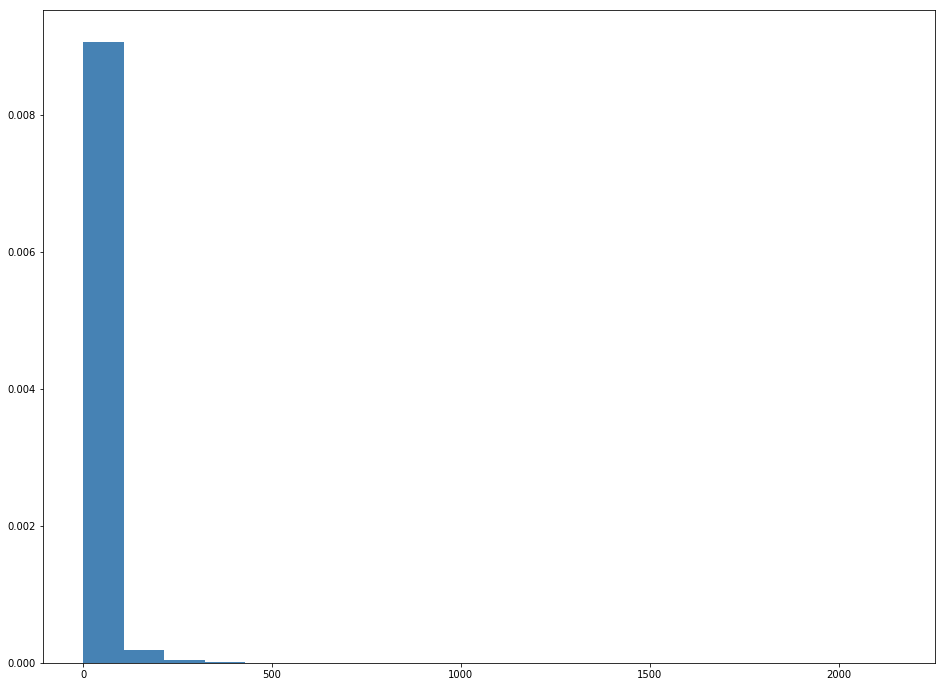

In [6]:
# on regarde l'histogramme des retards
fig = plt.figure(figsize=(16, 12))
plt.hist(data_fly.loc[:,'DEP_DELAY_NEW'], bins=20, color='steelblue',
            normed=True, edgecolor='none')
plt.show

on s'apperçoit, comme on pouvait s'y attendre que la grand majorité des retards sont inferieur à 200 minutes

In [7]:
# on choisit de ne garder que les retards de moins de 200mins 
print (data_fly.shape[0])
data_fly = data_fly[data_fly['DEP_DELAY_NEW'] < 200]
print (data_fly.shape[0])

5572218
5531763


In [8]:
# étudier la correlation entre le retard au départ et le départ à l'arrivée 
print ("voici la correlation linéaire entre le retard au départ et le retard à l'arrivée")
print (data_fly.iloc[:,0:2].corr(method='pearson'))

voici la correlation linéaire entre le retard au départ et le retard à l'arrivée
               DEP_DELAY_NEW  ARR_DELAY_NEW
DEP_DELAY_NEW       1.000000       0.935217
ARR_DELAY_NEW       0.935217       1.000000


In [9]:
# on peut surpprimer un des deux : 
data_fly = data_fly.drop(columns = ['ARR_DELAY_NEW'])

In [10]:
print (data_fly.columns[:])

Index(['DEP_DELAY_NEW', 'CANCELLED', 'DIVERTED', 'DAY', 'DAY_YEAR', 'Friday',
       'Thursday', 'Monday', 'Wednesday', 'Tuesday', 'Sunday', 'Saturday',
       'HOUR', 'MINUTES', '6', '8', '10', '7', '12', '18', '17', '14', '16',
       '11', '15', '9', '13', '20', '19', '21', '22', '5', '23', '24', '0',
       '1', '2', '3', '4'],
      dtype='object')


In [11]:
# mélanger les données : 
data_fly = shuffle(data_fly)

In [12]:
# diviser le jeux par n
n = 100 
data_fly = data_fly.iloc[0:int(np.around((data_fly.shape[0])/n)),:]


In [13]:
# on commence par définir des fonctions importantes dans la suite de notre travail

# il n'y a pas de raison de suggérer une continuité particulière en fonction des jours de la semaine
# nous choisisson donc d'ajouter 7 variables suplémentaires 
# commençons par définir les fonctions appropriées 

# define a new function wich is doing the pretty the same as the function "associate" but to find 
# path features

# détermine le nombre, les occurences / les pourcentages des objets pour une variable donnée

def plot_value_counts(col_name):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)

def plot_value_counts2(col_name,n_oc):
        
    #we don't want more than 31 bars
    if len(pd.DataFrame(df[col_name].dropna().value_counts())) > n_oc:
        max = n_oc
    else:
        max = len(pd.DataFrame(df[col_name].dropna().value_counts()))       
        
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts()[:max])
    print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)

In [14]:
# établir les retards en fonction des dates : 

df = data_fly
valeurs = plot_value_counts('DAY_YEAR')
print (valeurs.shape)

print (valeurs.dtypes)
valeurs.iloc[:,0] = pd.to_numeric(valeurs.iloc[:,0], errors='coerce').fillna(0, downcast='infer')
print (valeurs.dtypes)
for i in range (valeurs.shape[0]):
    if (valeurs.iloc[i,0] == 9):
        print ("yes")
#print (valeurs.shape)
# associer à valeurs.loc[:,'FL_DATE'] format date
#valeurs['DAY'] = valeurs.iloc[:,0].dt.dayofyear
# sommer la quantité de retard 
retard_dep = []
index_dep = data_fly.columns.get_loc('DEP_DELAY_NEW')


for i in range (valeurs.shape[0]):
    df = data_fly[(data_fly['DAY_YEAR']) == (valeurs.iloc[i,0])]
    retard_dep.append((df.iloc[:,index_dep].sum(axis=0))/valeurs.iloc[i,1])
    
valeurs['poid_dep'] = retard_dep[:]
    

(366, 1)
(366, 3)
DAY_YEAR     object
count         int64
percent     float64
dtype: object
DAY_YEAR      int64
count         int64
percent     float64
dtype: object
yes


In [15]:
# creation des tenseurs numpy 
# creation des vecteurs X et y 
# variables éventuelles 
X = np.matrix(data_fly.iloc[:,3::])
# scores éventuels 
y = np.matrix(data_fly.iloc[:,0:3])

#X = np.transpose(X)
#y = np.transpose(y)
print (X.shape)
print (y.shape)

(55318, 36)
(55318, 3)


In [16]:
# créer un jeux de test et un jeux d'entrainement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37063, 36) (18255, 36) (37063, 3) (18255, 3)


# REGRESSION SUR LES JOURS DE LA SEMAINE ENCODES

In [17]:
# On crée un modèle de régression linéaire
lr = linear_model.Ridge()
params = {'alpha': np.logspace(2,4 , 10) }
X_fit = X_train[:,2:9]
y_fit = y_train[:,0]
model_ridge_cv = GridSearchCV(lr,params,cv=5)
model_ridge_cv.fit(X_fit,y_fit)
# prédire les valeurs de y_test
y_predict_lr = model_ridge_cv.predict(X_test[:,2:9])
print (X_fit.shape)

(37063, 7)


In [18]:
print (params)

{'alpha': array([  100.        ,   166.81005372,   278.25594022,   464.15888336,
         774.26368268,  1291.54966501,  2154.43469003,  3593.8136638 ,
        5994.84250319, 10000.        ])}


In [19]:
print ('-------voici le meilleur paramètre---------')
print (model_ridge_cv.best_params_)

-------voici le meilleur paramètre---------
{'alpha': 1291.549665014884}


In [20]:
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0])))

RMSE : 25.50


In [21]:
# comparer à un classifieur naif 
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_fit, y_fit)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test[:,2:9])

# Evaluate
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred_dum[:,0])))

RMSE : 25.50


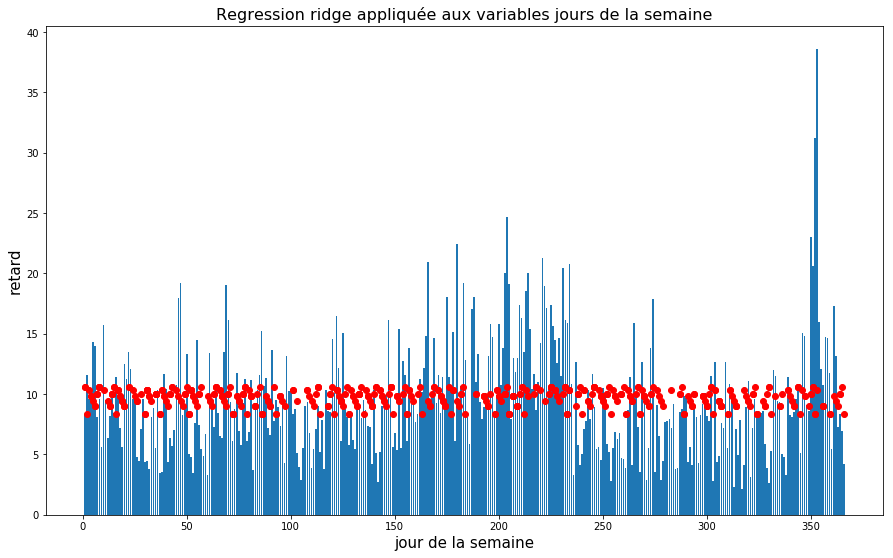

In [22]:
# visualisation 
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
plt.bar(x=valeurs.iloc[:,0],height=valeurs.iloc[:,3])
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.title("Regression ridge appliquée aux variables jours de la semaine",fontsize=16)

ax1.set_xlabel("jour de la semaine",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.plot(X_test[0:500,1], y_predict_lr[0:500,:],'ro', markersize=6, c='red')
plt.show()

# Regression sur les jours de l'année en considérant uniquement les jours de l'année

In [23]:
X_fit = X_train[:,1]
y_fit = y_train[:,0] 
X_test_n = X_test[:,1]
# ajouter des features polynomiales 
poly = PolynomialFeatures(8)
X_fit = poly.fit_transform(X_fit)

X_test_n = poly.fit_transform(X_test[:,1])

In [24]:
# On crée un modèle de régression linéaire
lr = linear_model.Ridge()
params = {'alpha': np.logspace(3,5 , 10) }

model_ridge_cv = GridSearchCV(lr,params,cv=5)
model_ridge_cv.fit(X_fit,y_fit)
# prédire les valeurs de y_test
y_predict_lr = model_ridge_cv.predict(X_test_n)

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.054705e-42
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.025735e-42
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.998807e-42
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.062218e-42
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.523776e-40
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.535329e-40
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.524918e-40
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.515241e-40
  overwrite_a=True).T
C:\Users

In [25]:
print (params)

{'alpha': array([  1000.        ,   1668.1005372 ,   2782.55940221,   4641.58883361,
         7742.63682681,  12915.49665015,  21544.34690032,  35938.13663805,
        59948.42503189, 100000.        ])}


In [26]:
print ('-------voici le meilleur paramètre---------')
print (model_ridge_cv.best_params_)

-------voici le meilleur paramètre---------
{'alpha': 1000.0}


In [27]:
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0])))

RMSE : 25.41


In [28]:
# comparer à un classifieur naif 
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_fit, y_fit)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_n)

# Evaluate
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred_dum[:,0])))

RMSE : 25.50


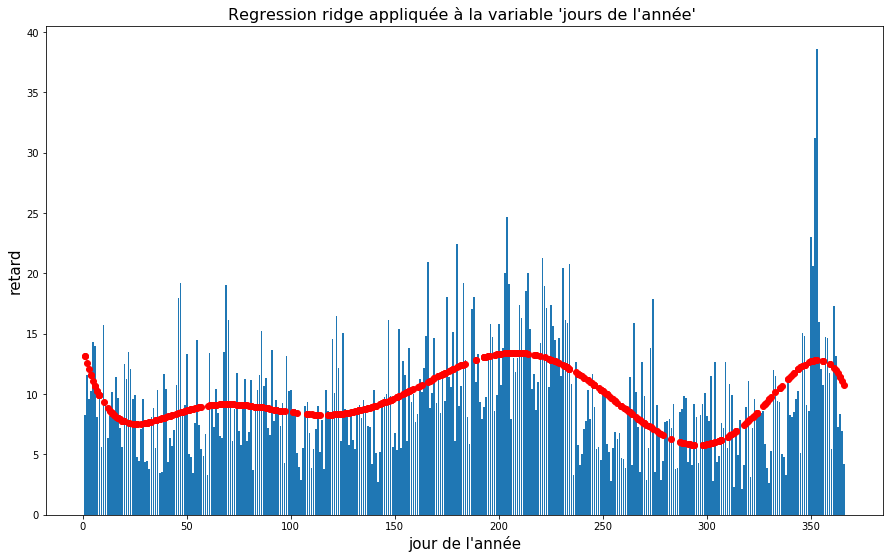

In [29]:
# visualisation 
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
plt.bar(x=valeurs.iloc[:,0],height=valeurs.iloc[:,3])
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.plot(X_test[0:500,1], y_predict_lr[0:500,:],'ro', markersize=6, c='red')
plt.title("Regression ridge appliquée à la variable 'jours de l'année' ",fontsize=16)

ax1.set_xlabel("jour de l'année",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.savefig('pict_reg_time1', dpi=400)
plt.show()

# Regression sur les jours de l'année en considérant aussi les jours de la semaines encodés 

In [30]:
# ajouter des features polynomiales uniquement à la variable "jour de l'année"
poly = PolynomialFeatures(8)
X_fit = poly.fit_transform(X_train[:,1])
X_fit = np.concatenate((X_fit,X_train[:,2:9]),axis=1)
y_fit = y_train[:,0] 

X_test_n = poly.fit_transform(X_test[:,1])
X_test_n = np.concatenate((X_test_n,X_test[:,2:9]),axis=1)

In [31]:
# On crée un modèle de régression linéaire
lr = linear_model.Ridge()
params = {'alpha': np.logspace(2,5 , 10) }

model_ridge_cv = GridSearchCV(lr,params,cv=5)
model_ridge_cv.fit(X_fit,y_fit)
# prédire les valeurs de y_test
y_predict_lr = model_ridge_cv.predict(X_test_n)

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.052655e-43
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.023904e-43
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.996446e-43
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.059431e-43
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.512596e-40
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.507291e-40
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.500029e-40
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.512302e-40
  overwrite_a=True).T
C:\Users

In [32]:
print (params)

{'alpha': array([   100.        ,    215.443469  ,    464.15888336,   1000.        ,
         2154.43469003,   4641.58883361,  10000.        ,  21544.34690032,
        46415.88833613, 100000.        ])}


In [33]:
print ('-------voici le meilleur paramètre---------')
print (model_ridge_cv.best_params_)

-------voici le meilleur paramètre---------
{'alpha': 1000.0}


In [34]:
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0])))

RMSE : 25.41


In [35]:
# comparer à un classifieur naif 
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_fit, y_fit)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_n)

# Evaluate
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred_dum[:,0])))

RMSE : 25.50


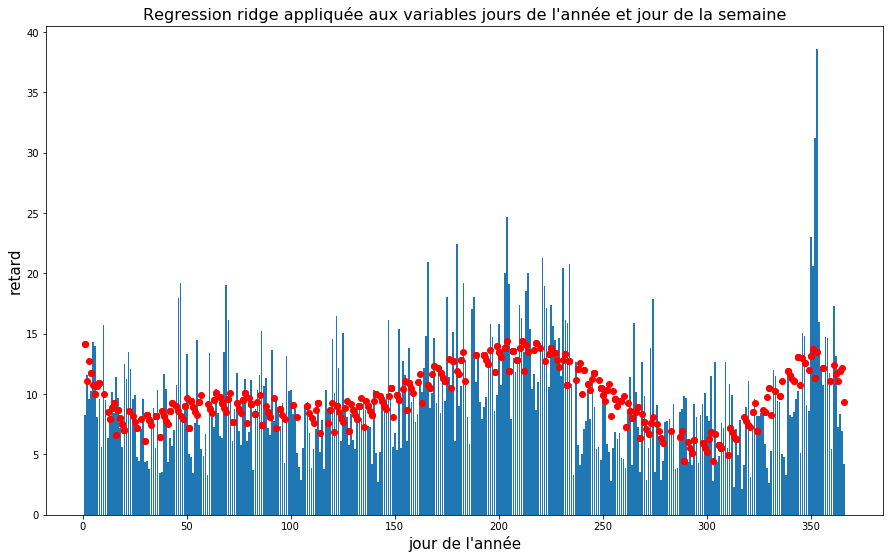

In [36]:
# visualisation 
# Set up the matplotlib figure
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

plt.bar(x=valeurs.iloc[:,0],height=valeurs.iloc[:,3])
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.plot(X_test[0:500,1], y_predict_lr[0:500,:],'ro', markersize=6, c='red')
plt.title("Regression ridge appliquée aux variables jours de l'année et jour de la semaine",fontsize=16)

ax1.set_xlabel("jour de l'année",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.savefig('pict_reg_time2', dpi=400)
plt.show()

# Regression en considérant l'heure seule 

In [37]:
# ajouter des features polynomiales uniquement à la variable "jour de l'année"
poly = PolynomialFeatures(8)
X_fit = poly.fit_transform(X_train[:,10])
X_test_n = poly.fit_transform(X_test[:,10])
y_fit = y_train[:,0] 

In [38]:
# On crée un modèle de régression linéaire
lr = linear_model.Ridge()
params = {'alpha': np.logspace(8 , 10) }

model_ridge_cv = GridSearchCV(lr,params,cv=5)
model_ridge_cv.fit(X_fit,y_fit)
# prédire les valeurs de y_test
y_predict_lr = model_ridge_cv.predict(X_test_n)

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.351060e-46
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.464221e-46
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.313928e-46
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.380761e-46
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.063936e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.034608e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.047553e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.050573e-45
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.011588e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.054138e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.997515e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.022508e-45
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.786043e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.654114e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.712347e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.725933e-45
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.940689e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.015096e-44
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.871148e-45
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.994656e-45
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.959844e-44
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.905820e-44
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.929666e-44
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.935229e-44
  overwrite_a=True).T
C:\Users

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.679563e-44
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.725602e-44
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.736343e-44
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.070628e-44
  overwrite_a=True).T
C:\Users

In [39]:
print (params)

{'alpha': array([1.00000000e+08, 1.09854114e+08, 1.20679264e+08, 1.32571137e+08,
       1.45634848e+08, 1.59985872e+08, 1.75751062e+08, 1.93069773e+08,
       2.12095089e+08, 2.32995181e+08, 2.55954792e+08, 2.81176870e+08,
       3.08884360e+08, 3.39322177e+08, 3.72759372e+08, 4.09491506e+08,
       4.49843267e+08, 4.94171336e+08, 5.42867544e+08, 5.96362332e+08,
       6.55128557e+08, 7.19685673e+08, 7.90604321e+08, 8.68511374e+08,
       9.54095476e+08, 1.04811313e+09, 1.15139540e+09, 1.26485522e+09,
       1.38949549e+09, 1.52641797e+09, 1.67683294e+09, 1.84206997e+09,
       2.02358965e+09, 2.22299648e+09, 2.44205309e+09, 2.68269580e+09,
       2.94705170e+09, 3.23745754e+09, 3.55648031e+09, 3.90693994e+09,
       4.29193426e+09, 4.71486636e+09, 5.17947468e+09, 5.68986603e+09,
       6.25055193e+09, 6.86648845e+09, 7.54312006e+09, 8.28642773e+09,
       9.10298178e+09, 1.00000000e+10])}


In [40]:
print ('-------voici le meilleur paramètre---------')
print (model_ridge_cv.best_params_)

-------voici le meilleur paramètre---------
{'alpha': 5179474679.231202}


In [41]:
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0])))

RMSE : 25.21


In [42]:
# comparer à un classifieur naif 
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_fit, y_fit)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_n)

# Evaluate
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred_dum[:,0])))

RMSE : 25.50


In [43]:
# visualise les heures dans la journée 
df = data_fly
valeurs2 = plot_value_counts('HOUR')
valeurs2.iloc[:,0] = pd.to_numeric(valeurs2.iloc[:,0], errors='coerce').fillna(0, downcast='infer')

# sommer la quantité de retard 
retard_dep = []
index_dep = data_fly.columns.get_loc('DEP_DELAY_NEW')

for i in range (valeurs2.shape[0]):
    df = data_fly[(data_fly['HOUR']) == (valeurs2.iloc[i,0])]
    retard_dep.append((df.iloc[:,index_dep].sum(axis=0))/valeurs2.iloc[i,1])
    
valeurs2['poid_dep'] = retard_dep[:]

(25, 1)


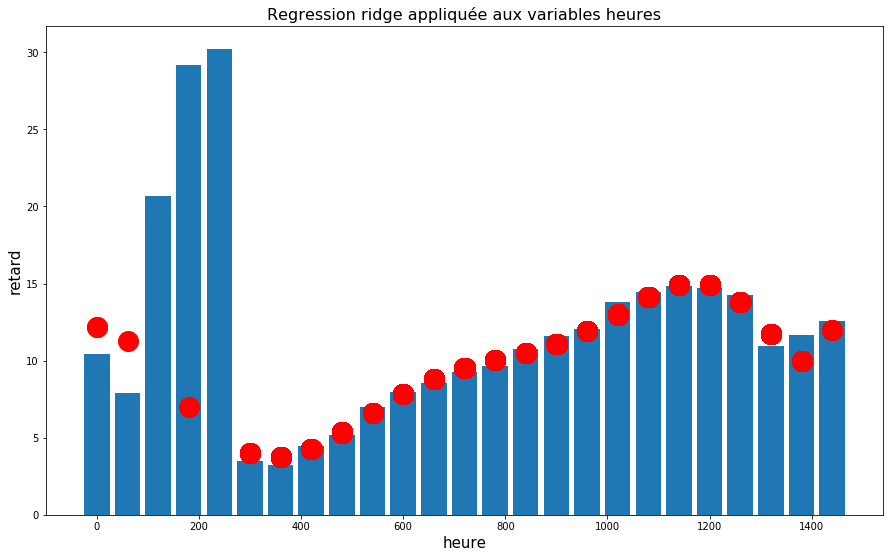

In [44]:
# visualisation minutes
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
plt.bar(x=valeurs2.iloc[:,0]*60,height=valeurs2.iloc[:,3],width=50)
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.title("Regression ridge appliquée aux variables heures",fontsize=16)

ax1.set_xlabel("heure",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.plot(X_test[0:1000,10], y_predict_lr[0:1000,:],'ro',markersize=20, c='red')
plt.show()

# Regression en considérant l'heure et les jours de l'année 

In [45]:
# ajouter des features polynomiales non couplées 
poly = PolynomialFeatures(8)
X_fit = poly.fit_transform(X_train[:,1])
X_fit = np.concatenate((X_fit,poly.fit_transform(X_train[:,10])),axis=1)


y_fit = y_train[:,0] 

X_test_n = poly.fit_transform(X_test[:,1])
X_test_n = np.concatenate((X_test_n,poly.fit_transform(X_test[:,10])),axis=1)

print (X_fit.shape)
print (X_test_n.shape)

(37063, 18)
(18255, 18)


In [46]:
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
X_fit = std_scale.transform(X_fit)
X_test_n= std_scale.transform(X_test_n)

In [47]:
# On crée un modèle de régression linéaire
lr = linear_model.Ridge()
params = {'alpha': np.logspace(-5,-1 , 10) }

model_ridge_cv = GridSearchCV(lr,params,cv=5)
model_ridge_cv.fit(X_fit,y_fit)
# prédire les valeurs de y_test
y_predict_lr = model_ridge_cv.predict(X_test_n)

In [48]:
print (params)
print ('-------voici le meilleur paramètre---------')
print (model_ridge_cv.best_params_)

{'alpha': array([1.00000000e-05, 2.78255940e-05, 7.74263683e-05, 2.15443469e-04,
       5.99484250e-04, 1.66810054e-03, 4.64158883e-03, 1.29154967e-02,
       3.59381366e-02, 1.00000000e-01])}
-------voici le meilleur paramètre---------
{'alpha': 1e-05}


In [49]:
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0])))

RMSE : 25.11


In [50]:
# comparer à un classifieur naif 
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_fit, y_fit)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_n)

# Evaluate
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred_dum[:,0])))

RMSE : 25.50


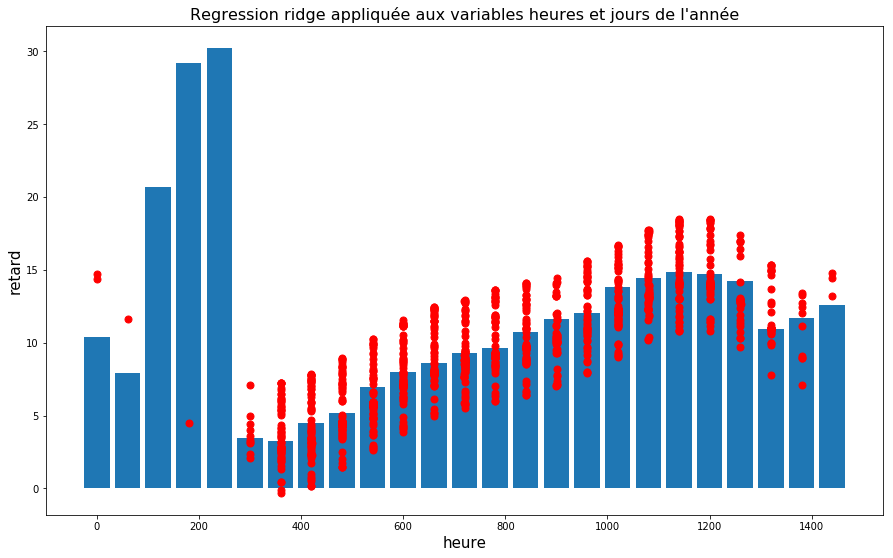

In [51]:
# visualisation minutes
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
plt.bar(x=valeurs2.iloc[:,0]*60,height=valeurs2.iloc[:,3],width=50)
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.title("Regression ridge appliquée aux variables heures et jours de l'année",fontsize=16)

ax1.set_xlabel("heure",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.plot(X_test[0:1000,10], y_predict_lr[0:1000,:],'ro',markersize=7, c='red')
plt.show()

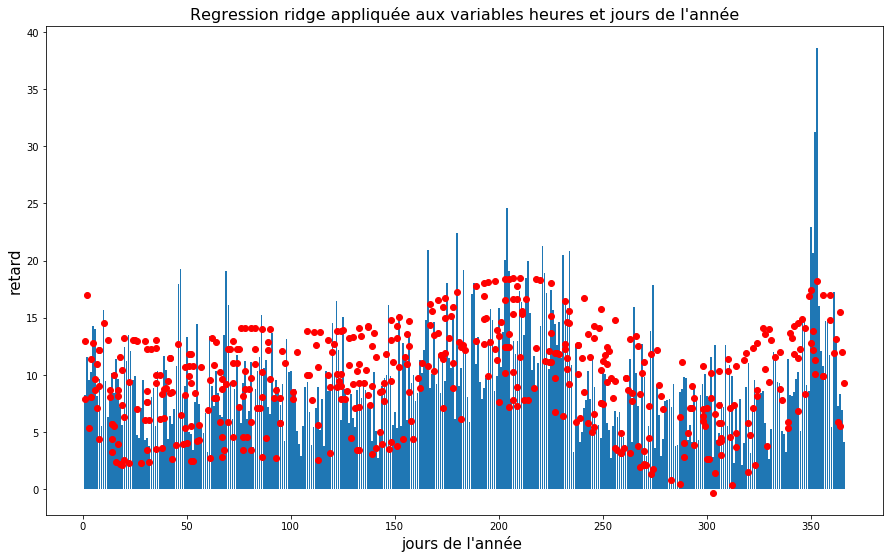

In [52]:
# visualisation jours de l'année
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
plt.title("Regression ridge appliquée aux variables heures et jours de l'année",fontsize=16)

ax1.set_xlabel("jours de l'année ",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.bar(x=valeurs.iloc[:,0],height=valeurs.iloc[:,3])
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.plot(X_test[0:500,1], y_predict_lr[0:500,:],'ro', markersize=6, c='red')
plt.show()

# Regression en considérant l'heure, les jours de l'année et les jours de la semaine encodés 

In [53]:
# ajouter des features polynomiales non couplées 
poly = PolynomialFeatures(20)
X_fit = poly.fit_transform(X_train[:,1])
X_fit = np.concatenate((X_fit,poly.fit_transform(X_train[:,10]),X_train[:,2:9]),axis=1)


y_fit = y_train[:,0] 

X_test_n = poly.fit_transform(X_test[:,1])
X_test_n = np.concatenate((X_test_n,poly.fit_transform(X_test[:,10]),X_test[:,2:9]),axis=1)

print (X_fit.shape)
print (X_test_n.shape)
print (X_train[:,2:8].shape)

(37063, 49)
(18255, 49)
(37063, 6)


In [54]:
# on va standardiser les données de telle sorte à ce que 
std_scale = preprocessing.StandardScaler().fit(X_fit)
X_fit = std_scale.transform(X_fit)
X_test_n= std_scale.transform(X_test_n)

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [55]:
# On crée un modèle de régression linéaire
lr = linear_model.Ridge()
params = {'alpha': np.logspace(-12,-10 , 10) }

model_ridge_cv = GridSearchCV(lr,params,cv=5)
model_ridge_cv.fit(X_fit,y_fit)
# prédire les valeurs de y_test
y_predict_lr = model_ridge_cv.predict(X_test_n)

C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.166672e-17
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.117157e-18
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.738386e-17
  overwrite_a=True).T
C:\Users\tanne\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.268774e-17
  overwrite_a=True).T
C:\Users

In [56]:
print (params)
print ('-------voici le meilleur paramètre---------')
print (model_ridge_cv.best_params_)

{'alpha': array([1.00000000e-12, 1.66810054e-12, 2.78255940e-12, 4.64158883e-12,
       7.74263683e-12, 1.29154967e-11, 2.15443469e-11, 3.59381366e-11,
       5.99484250e-11, 1.00000000e-10])}
-------voici le meilleur paramètre---------
{'alpha': 5.994842503189421e-11}


In [57]:
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0])))

RMSE : 25.07


In [58]:
# comparer à un classifieur naif 
dum = dummy.DummyRegressor(strategy='mean')

# Entraînement
dum.fit(X_fit, y_fit)

# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_n)

# Evaluate
print ("RMSE : %.2f" % np.sqrt(metrics.mean_squared_error(y_test[:,0], y_pred_dum[:,0])))

RMSE : 25.50


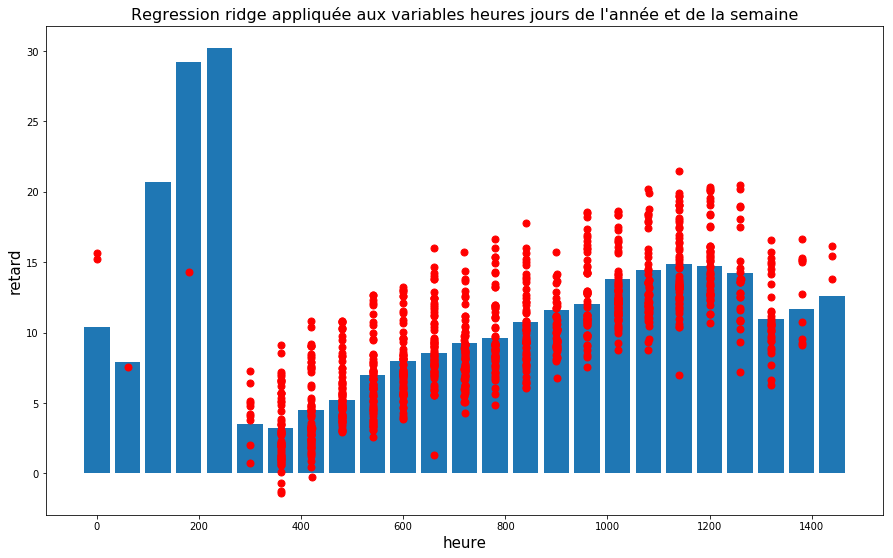

In [59]:
# visualisation minutes
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
plt.title("Regression ridge appliquée aux variables heures jours de l'année et de la semaine",fontsize=16)

ax1.set_xlabel("heure",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.bar(x=valeurs2.iloc[:,0]*60,height=valeurs2.iloc[:,3],width=50)
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.plot(X_test[0:1000,10], y_predict_lr[0:1000,:],'ro',markersize=7, c='red')
plt.show()

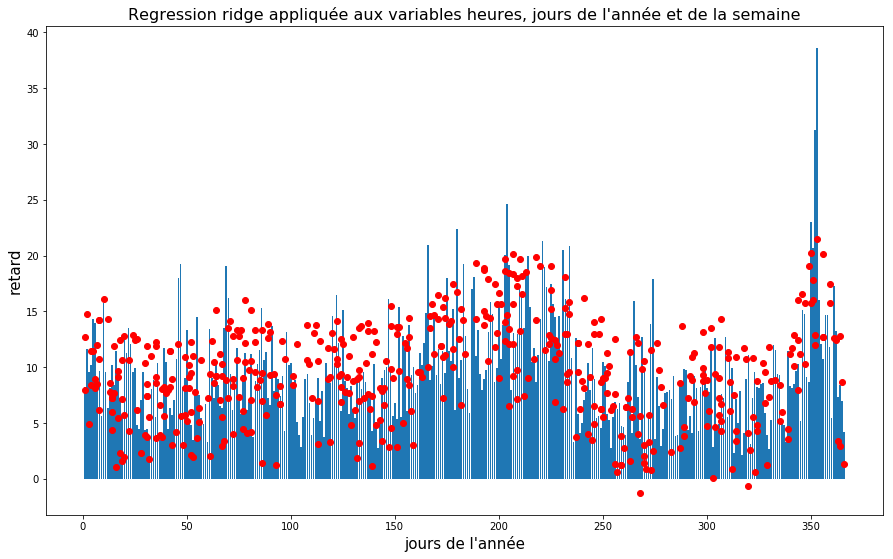

In [60]:
# visualisation jours de l'année
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)
plt.title("Regression ridge appliquée aux variables heures, jours de l'année et de la semaine",fontsize=16)

ax1.set_xlabel("jours de l'année",fontsize=15)
ax1.set_ylabel("retard",fontsize=15)
plt.bar(x=valeurs.iloc[:,0],height=valeurs.iloc[:,3])
#plt.plot(X_test[0:500,:], y_pred[0:500,:], linestyle='-', c='red') 
plt.plot(X_test[0:500,1], y_predict_lr[0:500,:],'ro', markersize=6, c='red')
plt.show()

In [61]:
# regarder si plus de données nous apportent de l'information
# On crée un modèle de régression 
lr = linear_model.Ridge()
params = {'alpha': np.logspace(-4,4 , 10) }

model_ridge_cv = GridSearchCV(lr,params,cv=5)


# diviser le dataset d'entrainement en n part de m exemples : n*m = X_train.shape[0]
n = 50
error = np.zeros(n-1)


for i in range (n):
    if i>0 :
        lr = linear_model.Ridge()
        params = {'alpha': np.logspace(-4,4 , 10) }

        model_ridge_cv = GridSearchCV(lr,params,cv=5)
        # On entraîne ce modèle sur les données d'entrainement    
        
        X_fit_n = X_fit[0:int(np.around(i*(X_train.shape[0])/n))-1,:]
        y_fit_n = y_fit[0:int(np.around(i*(X_train.shape[0])/n))-1,:]
        model_ridge_cv.fit(X_fit_n,y_fit_n)

        # prédire les valeurs de y_test
        y_predict_lr =  model_ridge_cv.predict(X_test_n)

        # quantifier l'erreur quadratique moyenne : 
        error[i-1] = np.sqrt(metrics.mean_squared_error(y_test[:,0], y_predict_lr[:,0]))
        print (params)
        print ('-------voici le meilleur paramètre---------')
        print (model_ridge_cv.best_params_)
        

{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 1291.5496650148827}
{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.0001}
{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.0001}
{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur param

{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.0001}
{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.0001}
{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur paramètre---------
{'alpha': 0.0001}
{'alpha': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])}
-------voici le meilleur paramètre--------

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]
[25.42664229 25.33959559 25.25820282 25.19657754 25.16096455 25.13256098
 25.12884331 25.12392933 25.09878289 25.09680452 25.09758219 25.09537822
 25.09199161 25.0943133  25.09362283 25.08975048 25.09057275 25.08668081
 25.08462234 25.08539403 25.08307644 25.0813719  25.07757362 25.07681283
 25.07787033 25.07820999 25.07696435 25.07732432 25.07751185 25.07761541
 25.07724806 25.07749652 25.07998165 25.07830376 25.08050355 25.08140702
 25.08188758 25.0827113  25.08298505 25.08303318 25.08137672 25.07960326
 25.07860097 25.07873239 25.07910129 25.07897192 25.07908537 25.07989541
 25.07992633]
25.076812830032086
25.42664228605403


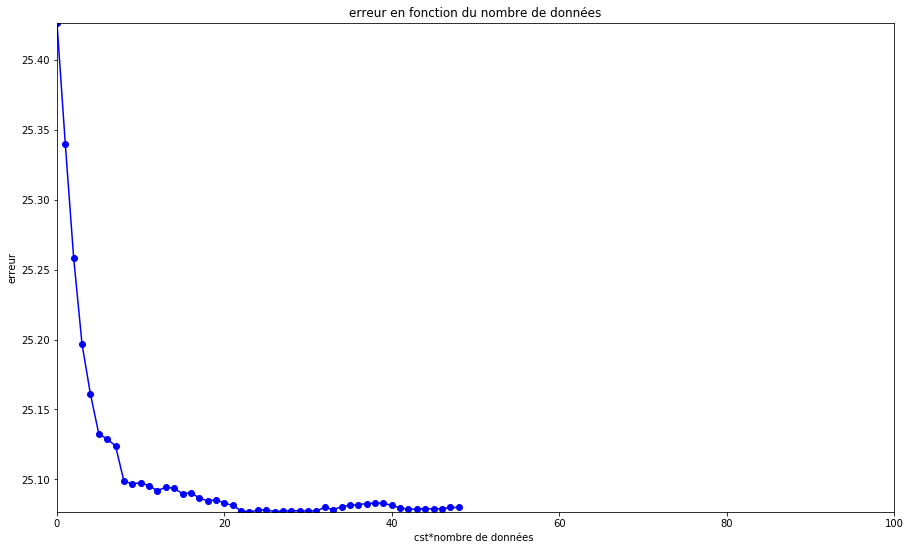

In [62]:
# regarder si plus de données nous apportent de l'information
f, (ax1) = plt.subplots(1, 1, figsize=(15, 9), sharex=True)

plt.title("erreur en fonction du nombre de données")
plt.xlabel("cst*nombre de données ")
plt.ylabel('erreur')

indice = np.zeros(n-1)
a = -1
for i in range (n-1):
    a = a + 1

    indice[i] = a 
print (indice)
print (error)
plt.plot(indice[:], error[:], linestyle='-', c='blue') 
plt.plot(indice[:], error[:], 'ro', markersize=6, c='blue')

#plt.plot(X_droite[:,1], y_droite, linestyle='--', c='red')
#plt.plot(X[:,1], y_predict, linestyle='-', c='blue')
plt.axis([0, 100, np.amin(error[:]), np.amax(error[:])])

print (np.amin(error[:]))
print (np.amax(error[:]))

plt.show()

